In [1]:
# 15m 收在下布林，且下影線大於實體Ｋ及上影線
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = 1000

# start epoch till now
start_time = 1669877807000
# end_time = round(time.time() * 1000)
end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 # 15min

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        df = pd.concat([df, out], axis = 0)
    
    return df

In [5]:
df = get_historical(symbol, interval, start_time, end_time, step)

# filter columns, adjust data type
df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
df = df.astype(convert_dict)

# adjust time to readable format and adjust timezone
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit = 'ms')
df['Close_Time'] = df['Close_Time'] + pd.Timedelta(hours=timezone)

# set proper index
df = df.reset_index(drop=True)

# for further iterations, to prevent time consumption in fetching raw data 
rawdf = df.copy()

print(df)


                        Close_Time     Open    Close     High      Low  \
0    2022-12-01 15:14:59.999000064  1284.52  1282.20  1284.81  1280.63   
1    2022-12-01 15:29:59.999000064  1282.18  1281.21  1283.27  1280.46   
2    2022-12-01 15:44:59.999000064  1281.22  1282.69  1282.88  1280.07   
3    2022-12-01 15:59:59.999000064  1282.69  1278.76  1282.79  1278.60   
4    2022-12-01 16:14:59.999000064  1278.76  1279.99  1280.97  1277.28   
...                            ...      ...      ...      ...      ...   
2971 2023-01-01 13:59:59.999000064  1194.09  1194.54  1194.67  1194.09   
2972 2023-01-01 14:14:59.999000064  1194.55  1194.09  1195.23  1193.97   
2973 2023-01-01 14:29:59.999000064  1194.09  1194.60  1194.92  1194.09   
2974 2023-01-01 14:44:59.999000064  1194.59  1194.37  1194.60  1193.81   
2975 2023-01-01 14:59:59.999000064  1194.36  1194.81  1194.82  1194.11   

         Volume  
0     2675.4013  
1     2398.2892  
2     2253.5322  
3     3430.3344  
4     3954.0834  
...

In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi
0,2022-12-01 15:14:59.999000064,1284.52,1282.20,1284.81,1280.63,2675.4013,NaN,NaN,NaN,NaN,NaN
1,2022-12-01 15:29:59.999000064,1282.18,1281.21,1283.27,1280.46,2398.2892,NaN,NaN,NaN,NaN,NaN
2,2022-12-01 15:44:59.999000064,1281.22,1282.69,1282.88,1280.07,2253.5322,NaN,NaN,NaN,NaN,NaN
3,2022-12-01 15:59:59.999000064,1282.69,1278.76,1282.79,1278.60,3430.3344,NaN,NaN,NaN,NaN,NaN
4,2022-12-01 16:14:59.999000064,1278.76,1279.99,1280.97,1277.28,3954.0834,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2971,2023-01-01 13:59:59.999000064,1194.09,1194.54,1194.67,1194.09,520.3463,1194.715000,1197.545490,1194.715000,1191.884510,48.033990
2972,2023-01-01 14:14:59.999000064,1194.55,1194.09,1195.23,1193.97,1376.0106,1194.588333,1197.168158,1194.588333,1192.008509,45.815582
2973,2023-01-01 14:29:59.999000064,1194.09,1194.60,1194.92,1194.09,1068.8736,1194.535333,1197.045758,1194.535333,1192.024908,48.706889
2974,2023-01-01 14:44:59.999000064,1194.59,1194.37,1194.60,1193.81,642.7820,1194.495333,1196.976611,1194.495333,1192.014056,47.476504


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c2 收盤 小於 布林下

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1_1 & df.c1_2 & df.c2 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy
0,2022-12-01 15:14:59.999000064,1284.52,1282.20,1284.81,1280.63,2675.4013,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
1,2022-12-01 15:29:59.999000064,1282.18,1281.21,1283.27,1280.46,2398.2892,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
2,2022-12-01 15:44:59.999000064,1281.22,1282.69,1282.88,1280.07,2253.5322,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
3,2022-12-01 15:59:59.999000064,1282.69,1278.76,1282.79,1278.60,3430.3344,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
4,2022-12-01 16:14:59.999000064,1278.76,1279.99,1280.97,1277.28,3954.0834,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2023-01-01 13:59:59.999000064,1194.09,1194.54,1194.67,1194.09,520.3463,1194.715000,1197.545490,1194.715000,1191.884510,48.033990,False,False,False,False,False
2972,2023-01-01 14:14:59.999000064,1194.55,1194.09,1195.23,1193.97,1376.0106,1194.588333,1197.168158,1194.588333,1192.008509,45.815582,False,False,False,False,False
2973,2023-01-01 14:29:59.999000064,1194.09,1194.60,1194.92,1194.09,1068.8736,1194.535333,1197.045758,1194.535333,1192.024908,48.706889,False,False,False,False,False
2974,2023-01-01 14:44:59.999000064,1194.59,1194.37,1194.60,1193.81,642.7820,1194.495333,1196.976611,1194.495333,1192.014056,47.476504,True,True,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


                        Close_Time     Open    Close     High      Low  \
33   2022-12-01 23:29:59.999000064  1267.51  1267.36  1269.40  1262.77   
34   2022-12-01 23:44:59.999000064  1267.35  1268.91  1270.94  1264.02   
35   2022-12-01 23:59:59.999000064  1268.92  1271.54  1272.09  1268.13   
61   2022-12-02 06:29:59.999000064  1275.28  1278.26  1283.94  1275.28   
194  2022-12-03 15:44:59.999000064  1275.41  1277.01  1277.61  1273.36   
...                            ...      ...      ...      ...      ...   
2814 2022-12-30 22:44:59.999000064  1191.98  1192.08  1194.11  1189.29   
2943 2023-01-01 06:59:59.999000064  1197.89  1196.19  1197.89  1193.08   
2944 2023-01-01 07:14:59.999000064  1196.18  1195.57  1196.19  1193.60   
2945 2023-01-01 07:29:59.999000064  1195.58  1195.68  1196.70  1194.98   
2960 2023-01-01 11:14:59.999000064  1195.41  1193.20  1195.41  1192.28   

          Volume          sma         bb_u         bb_m         bb_l  \
33    15600.9516  1281.115000  1291.420

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)


result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per]}

result_df = pd.DataFrame(result)

print(result_df)



                       Close_Time     Open    Close     High      Low  \
0   2022-12-01 23:44:59.999000064  1267.35  1268.91  1270.94  1264.02   
1   2022-12-01 23:59:59.999000064  1268.92  1271.54  1272.09  1268.13   
2   2022-12-02 06:29:59.999000064  1275.28  1278.26  1283.94  1275.28   
3   2022-12-03 15:59:59.999000064  1277.00  1276.08  1277.90  1275.67   
4   2022-12-03 16:29:59.999000064  1275.50  1275.69  1276.23  1274.59   
..                            ...      ...      ...      ...      ...   
118 2022-12-30 16:14:59.999000064  1188.26  1189.81  1190.17  1188.16   
119 2022-12-30 22:44:59.999000064  1191.98  1192.08  1194.11  1189.29   
120 2023-01-01 07:14:59.999000064  1196.18  1195.57  1196.19  1193.60   
121 2023-01-01 07:29:59.999000064  1195.58  1195.68  1196.70  1194.98   
122 2023-01-01 11:14:59.999000064  1195.41  1193.20  1195.41  1192.28   

             sma         bb_u         bb_l        rsi position  entry_p  \
0    1280.745667  1291.941417  1269.549917  35.3

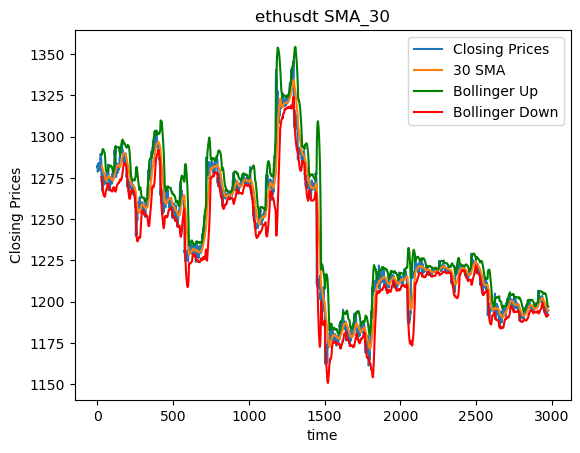

In [13]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()